In [2]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
data = sm.datasets.macrodata.load_pandas().data
data.head(5)

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [5]:
data1 = data[["realgdp", 'realdpi']]
data1.index = data["year"]
data1.head(5)

,realgdp,realdpi
year,,
1959.0,2710.349,1886.9
1959.0,2778.801,1919.7
1959.0,2775.488,1916.4
1959.0,2785.204,1931.3
1960.0,2847.699,1955.5


<AxesSubplot:xlabel='year'>

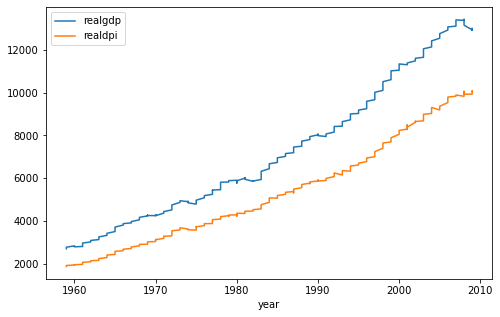

In [6]:
data1.plot(figsize = (8,5))

Before applying VAR, both the time series variable should be stationary. Both the series are not stationary since both the series do not show constant mean and variance over time. We can also perform a statistical test like the Augmented Dickey-Fuller test (ADF) to find stationarity of the series using the AIC criteria.

In [7]:
from statsmodels.tsa.stattools import adfuller
adfuller_test = adfuller(data1['realgdp'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 1.750462796764709
p-value: 0.9982455372335032


In [8]:
adfuller_test = adfuller(data1['realdpi'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 2.9860253519546864
p-value: 1.0


In [9]:
# realgdp series becomes stationary after 1st differencing
data_d = data1.diff().dropna()
adfuller_test = adfuller(data_d['realgdp'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -6.305695561658102
p-value: 3.327882187668259e-08


In [10]:
# realdpi series becomes stationary after 1st differencing
adfuller_test = adfuller(data_d['realdpi'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -8.864893340673008
p-value: 1.4493606159108096e-14


In [11]:
# train-test split of the data and keep the last 10-days as test data
train = data_d.iloc[:-10,:]
test = data_d.iloc[-10:,:]

In the process of VAR modeling, we opt to employ Information Criterion Akaike (AIC) as a model selection criterion to conduct optimal model identification. In simple terms, we select the order (p) of VAR based on the best AIC score. The AIC, in general, penalizes models for being too complex, though the complex models may perform slightly better on some other model selection criterion. Hence, we expect an inflection point in searching the order (p), meaning that, the AIC score should decrease with order (p) gets larger until a certain order and then the score starts increasing. For this, we perform grid-search to investigate the optimal order (p).

In [12]:
forecasting_model = VAR(train)
results_aic = []
for p in range(1,10):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

/Users/tomxu/miniforge3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


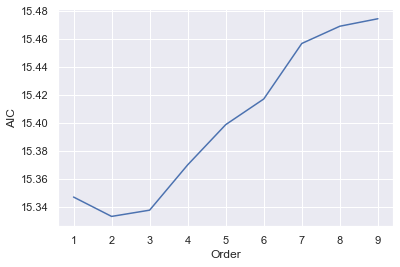

In [16]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set()
plt.plot(list(np.arange(1,10,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [17]:
results = forecasting_model.fit(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 26, Jun, 2021
Time:                     19:38:00
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    15.5043
Nobs:                     190.000    HQIC:                   15.4026
Log likelihood:          -1985.87    FPE:                4.56270e+06
AIC:                      15.3334    Det(Omega_mle):     4.33171e+06
--------------------------------------------------------------------
Results for equation realgdp
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             23.807343         6.111430            3.896           0.000
L1.realgdp         0.176227         0.078131            2.256           0.024
L1.realdpi         0.213713         0.085309            2.505         

We use 2 as the optimal order in fitting the VAR model. Thus, we take the final 2 steps in the training data for forecasting the immediate next step (i.e., the first day of the test data). Now, after fitting the model, we forecast for the test data where the last 2 days of training data set as lagged values and steps set as 10 days as we want to forecast for the next 10 days.

In [18]:
train.values[-2:]

array([[ 94.763, 126.3  ],
       [ 39.222,  41.4  ]])

In [19]:
laaged_values = train.values[-2:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=10), index = test.index, columns= ['realgdp_1d', 'realdpi_1d'])
forecast

,realgdp_1d,realdpi_1d
year,,
2007.0,61.872982,47.739232
2007.0,53.948996,41.742951
2007.0,56.171082,42.552316
2008.0,54.953081,42.023999
2008.0,55.109616,42.001007
2008.0,54.865410,41.937065
2008.0,54.841362,41.893996
2009.0,54.775171,41.878378
2009.0,54.754309,41.859837


We have to note that the aforementioned forecasts are for the one differenced model. Hence, we must reverse the first differenced forecasts into the original forecast values.


In [22]:
forecast_1D = forecast.copy()
forecast["realgdp_forecasted"] = data1["realgdp"].iloc[-10-1] + forecast_1D['realgdp_1d'].cumsum()
forecast["realdpi_forecasted"] = data1["realdpi"].iloc[-10-1] + forecast_1D['realdpi_1d'].cumsum()
forecast 

,realgdp_1d,realdpi_1d,realgdp_forecasted,realdpi_forecasted
year,,,,
2007.0,61.872982,47.739232,13161.773982,9877.939232
2007.0,53.948996,41.742951,13215.722978,9919.682183
2007.0,56.171082,42.552316,13271.894060,9962.234500
2008.0,54.953081,42.023999,13326.847141,10004.258499
2008.0,55.109616,42.001007,13381.956757,10046.259506
2008.0,54.865410,41.937065,13436.822166,10088.196571
2008.0,54.841362,41.893996,13491.663528,10130.090566
2009.0,54.775171,41.878378,13546.438699,10171.968945
2009.0,54.754309,41.859837,13601.193008,10213.828781
